© Copyright 2002–2019, Team SimPy

© Copyright 2019, Dataiku

# Event Based Monte-Carlo Simulation with Simpy

Based on the [Bank renege example](https://simpy.readthedocs.io/en/latest/examples/bank_renege.html) from Simpy documentation and completed with Monte-Carlo simulations of the impact of the number of counters.

*Scenario:*
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import random
import simpy
import numpy as np

import dataiku
from dataiku import insights

In [3]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience

In [4]:
def source(env, number, interval, counter, waitingTimes, renegedIndicators, printlevel):
    """Source generates customers randomly"""
    for i in range(number):
        time_in_bank=4.0
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank , waitingTimes, renegedIndicators, printlevel)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank, waitingTimes, renegedIndicators, printlevel):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    if (printlevel>0):
        print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive
        waitingTimes.append(wait)
        
        if req in results:
            # We got to the counter
            if (printlevel>0):
                print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            
            if (printlevel>0):
                print('%7.4f %s: Finished' % (env.now, name))
            
            renegedIndicators.append(False)
            
        else:
            # We reneged
            if (printlevel>0):
                print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))
                
            renegedIndicators.append(True)

## Test simulation

In [5]:
# Setup and start the simulation
print('Bank renege')
printlevel=1
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Logging arrays
waitingTimes      = []
renegedIndicators = []

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, waitingTimes, renegedIndicators, printlevel))
env.run()

print(waitingTimes)
print(renegedIndicators)

counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, waitingTimes, renegedIndicators, printlevel))
env.run()


Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 1.2865 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
14.7173 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
35.9862 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
41.3666 Customer04: Finished
[0, 0.0, 1.173877665258832, 0.0, 0.0]
[False, True, False, False, False]
47.5190 Customer00: Here I am
47.5190 Customer00: Waited  0.000
48.5151 Customer00: Finished
58.0139 Customer01: Here I am
58.0139 Customer01: Waited  0.000
58.0400 Customer01: Finished
66.9120 Customer02: Here I am
66.9120 Customer02: Waited  0.000
68.5756 Customer02: Finished
83.3016 Customer03: Here I am
83.3016 Customer03: Waited  0.000
84.9431 Customer03: Finished
84.9915 Customer04: Here I am
84.9915 Customer04: Waited  0.000
92.5137 Customer04: Finished


## Monte-Carlo simulation

The previous scenario is run many times to simulate many opening days with 1 and 2 counters. The histogram of the number of reneged customers is displayed in both cases.

1 counter(s) is not enough. The proportion of simulations out the target is: 0.894


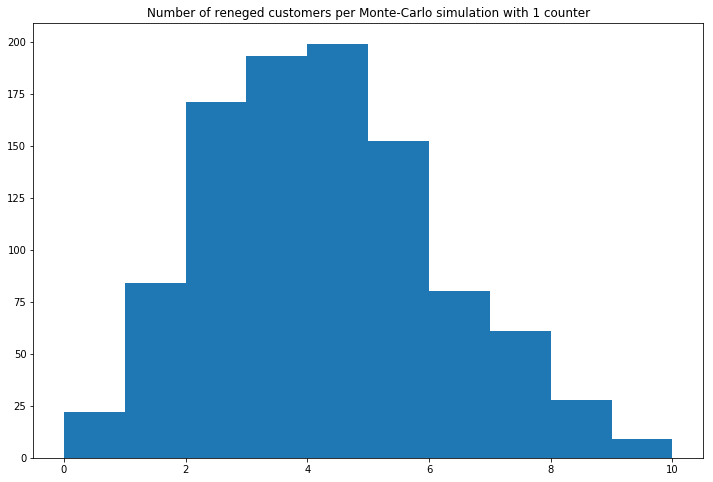

2 counter(s) is enough. The proportion of simulations out the target is: 0.1


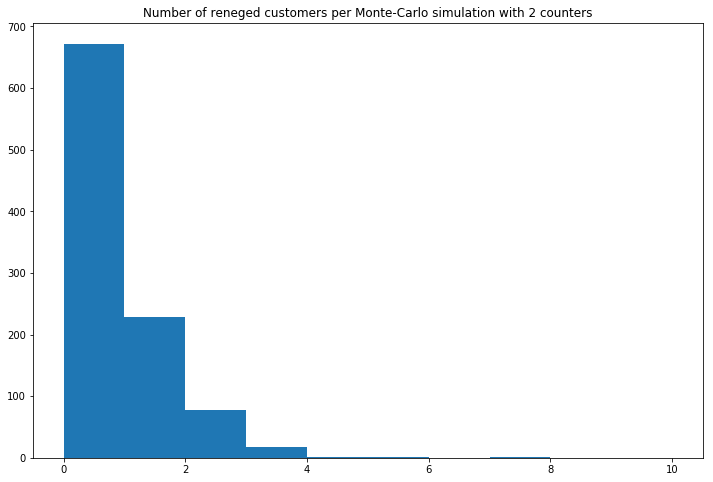

In [6]:
nbMCSimulations = 1000

NEW_CUSTOMERS_MC = 20
printlevel = 0

histoMax=1
for sc in range(2):
    nbCounters=(sc+1)
    renegedCount=np.empty([nbMCSimulations])
    for ind in range(nbMCSimulations):
        waitingTimes      = []
        renegedIndicators = []
        counter = simpy.Resource(env, capacity= nbCounters )
        env.process(source(env, NEW_CUSTOMERS_MC, INTERVAL_CUSTOMERS, counter, waitingTimes, renegedIndicators, printlevel))
        env.run()
        renegedCount[ind] = sum(renegedIndicators)

    #The company policy set that the proportion of customer target should be below 10% 90% of the time
    outOfTargetSimulations = sum(renegedCount>= (0.1*NEW_CUSTOMERS_MC) )* 1.0 /nbMCSimulations
    if (outOfTargetSimulations>0.1 ):
        print(str(nbCounters)+" counter(s) is not enough. The proportion of simulations out the target is: "+str(outOfTargetSimulations))
    else:
        print(str(nbCounters)+" counter(s) is enough. The proportion of simulations out the target is: "+str(outOfTargetSimulations))

    histoMax = max(histoMax, int(amax(renegedCount)))
    f, ax = plt.subplots(figsize=(12, 8))
    plt.hist(renegedCount, bins= range(histoMax) )
    if (sc==0):
        plt.title("Number of reneged customers per Monte-Carlo simulation with 1 counter")
        insights.save_figure("reneged-customers-1-counter",f)
    else:             
        plt.title("Number of reneged customers per Monte-Carlo simulation with 2 counters")
        insights.save_figure("reneged-customers-2-counters",f)
    plt.show()
    
